In [1]:
#!pip install -q kaggle folium
#!mkdir -p taxi

# Скачаем архив соревнования с Kaggle (нужен файл kaggle.json в ~/.kaggle)
#!kaggle competitions download -c nyc-taxi-trip-duration -p taxi

#!unzip -o taxi/nyc-taxi-trip-duration.zip -d taxi

#!unzip -o taxi/train.zip -d taxi
#!unzip -o taxi/test.zip -d taxi
#!unzip -o taxi/sample_submission.zip -d taxi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import folium
import seaborn as sns
import datetime as dt
%matplotlib inline

sns.set(style="darkgrid")

## Загрузка и первичный анализ данных

В этом проекте я решил поработать с реальными данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) на Kaggle. Задача — предсказать длительность поездки на такси по различным признакам, известным на момент начала поездки.

Первым делом скачаем обучающую выборку и загрузим её в pandas DataFrame. Один из важных шагов на этом этапе — предварительная очистка и преобразование данных. В частности, колонка `dropoff_datetime` содержит время окончания поездки, но в тестовой выборке она отсутствует, поэтому её использовать в обучении нельзя.

In [2]:
df = pd.read_csv('taxi/train.csv')

Колонка `pickup_datetime` содержит дату и время начала поездки. Чтобы с этой информацией было удобнее работать, я преобразовал её в `datetime`-формат pandas.

In [3]:
df.drop(columns='dropoff_datetime', inplace=True)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

Целевая переменная в этой задаче — `trip_duration`, то есть продолжительность поездки в секундах. Прежде чем строить модель, важно понять распределение этой переменной. Поэтому я визуализировал его с помощью гистограммы. Это помогает выявить выбросы, смещения и вообще оценить, насколько сложной будет задача регрессии.

<Axes: >

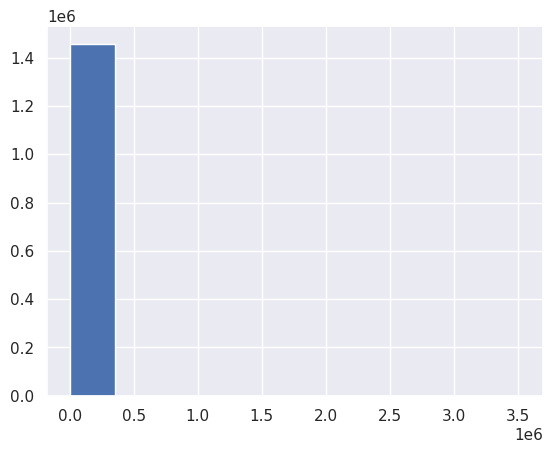

In [4]:
df['trip_duration'].hist()

По гистограмме `trip_duration` мы видим, что присутствует выброс

## Почему RMSLE, а не RMSE?

В этом соревновании качество модели оценивается по метрике **RMSLE** (Root Mean Squared Logarithmic Error), которая вычисляется по формуле:

$$
\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \left(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\right)^2}
$$

Почему организаторы соревнования предпочли её классической RMSE? Всё дело в свойствах логарифма. RMSLE **меньше наказывает за большие абсолютные ошибки на больших значениях** и **сильнее реагирует на относительные ошибки**, особенно на малых значениях. Это разумно в задаче предсказания длительности поездок: поездка на 2000 секунд может длиться на ±500 секунд дольше по ряду причин (пробка, объезд), и такие ошибки не критичны, в то время как ошибка в ±500 секунд на 300-секундной поездке — уже большая относительная погрешность. RMSLE справедливо учитывает эту асимметрию.

## От RMSLE к MSE: трюк с логарифмированием

В библиотеке `sklearn` модели линейной регрессии оптимизируют **MSE**, а не RMSLE. Чтобы обойти это ограничение, я использую следующий трюк: вместо исходного значения `trip_duration` я предсказываю его **логарифм**. Обозначим:

- $\hat{y}_i = \log(y_i + 1)$ — логарифм модифицированного таргета,
- $\hat{a}(x_i)$ — предсказание модели, обученной на логарифмах.

Если предсказание $\hat{a}(x_i)$ близко к $\hat{y}_i$, то это означает, что мы минимизируем обычную MSE по логарифмам. А финальное предсказание возвращаем как:

$$
a(x_i) = \exp(\hat{a}(x_i)) - 1
$$

**То есть: оптимизация RMSLE для модели $a$ ⇔ оптимизация MSE для модели $\hat{a}$**, потому что:

$$
\text{RMSLE} = \sqrt{\frac{1}{\ell} \sum_{i=1}^\ell \left( \log(y_i + 1) - \log(a(x_i) + 1) \right)^2} 
= \sqrt{\frac{1}{\ell} \sum_{i=1}^\ell \left( \hat{y}_i - \hat{a}(x_i) \right)^2}
= \text{RMSE}(\hat{y}, \hat{a}(x))
$$

Итак, мы доказали, что можно обучать модель на логарифмах и использовать обычную MSE.

In [5]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])

## Визуализация логарифмированного таргета

Добавляем в датафрейм колонку `log_trip_duration` с помощью `np.log1p()` (это безопасный логарифм: `log(1 + x)`, чтобы избежать `log(0)`). Далее построил гистограмму модифицированного таргета, чтобы оценить распределение. Логарифмирование помогает **сжать длинный правый хвост** в распределении и делает данные более нормальными, что полезно для линейных моделей.

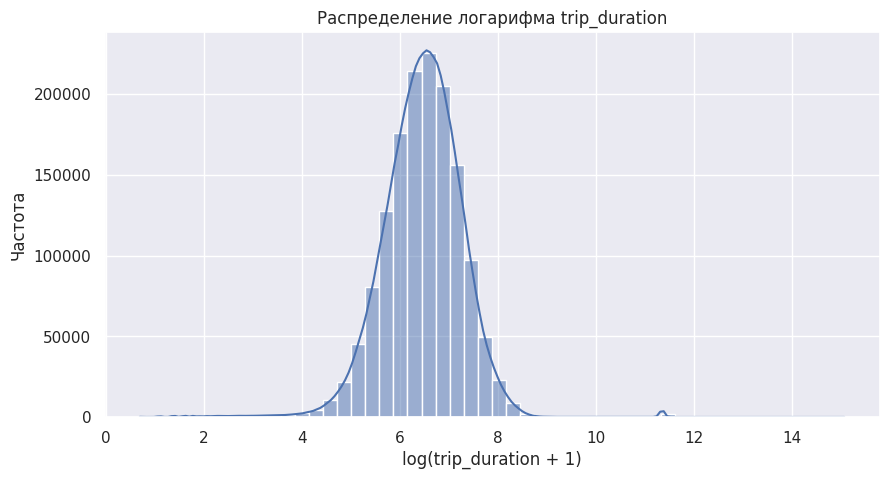

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(df['log_trip_duration'], bins=50, kde=True)
plt.title('Распределение логарифма trip_duration')
plt.xlabel('log(trip_duration + 1)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

## Базовая метрика: константное предсказание

Перед обучением моделей оценим качество константного предсказания. Это поможет понять, даёт ли модель реальное улучшение.

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
import numpy as np

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

y_train = df["log_trip_duration"].values

results = pd.DataFrame(columns=["RMSLE"])
results.loc["baseline"] = rmse(y_train, y_train.mean() * np.ones_like(y_train))
print(results)

             RMSLE
baseline  0.795759


## Анализ количества поездок по дням

Рассмотрим, как менялось количество поездок по дням. Для этого сгруппируем данные по дате и построим график. Это позволяет выявить пропущенные или аномальные дни, а также сезонные эффекты.

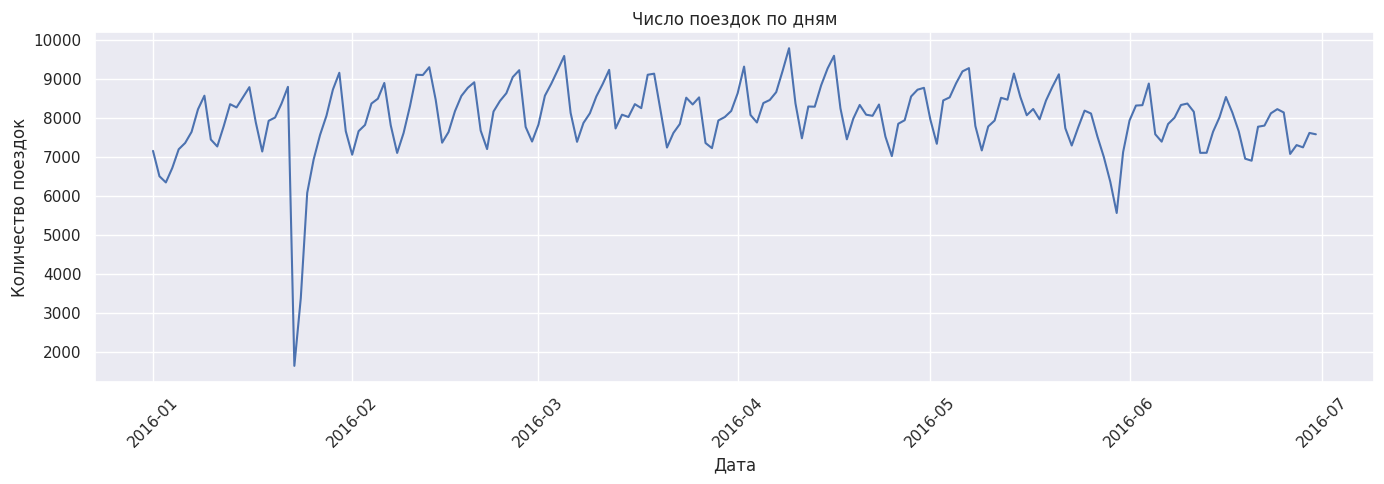

In [8]:
df["date"] = df["pickup_datetime"].dt.date
df["num_day"] = df["date"].apply(lambda x: x.timetuple().tm_yday)
trips_per_day = df.groupby("date").size().reset_index(name="count")

plt.figure(figsize=(14, 5))
sns.lineplot(data=trips_per_day, x="date", y="count")
plt.title("Число поездок по дням")
plt.xlabel("Дата")
plt.ylabel("Количество поездок")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Аномальные дни и анализ сезонности

На графике видно два резких провала в количестве поездок, а именно 2016-01-23 и 2016-01-24. В эти дни в Нью-Йорке прошёл один из сильнейших снежных штормов — **Blizzard Jonas**, из-за чего был временно остановлен общественный транспорт и введён запрет на передвижение частных автомобилей.

Также построим графики распределения количества поездок по дням недели и часам в сутках — чтобы понять, как поведение пользователей зависит от времени.

In [9]:
min_trips = trips_per_day.sort_values("count").head(5)
print(min_trips)

           date  count
22   2016-01-23   1648
23   2016-01-24   3383
150  2016-05-30   5570
24   2016-01-25   6084
2    2016-01-03   6353


In [10]:
df["weekday"] = df["pickup_datetime"].dt.weekday
df["hour"] = df["pickup_datetime"].dt.hour

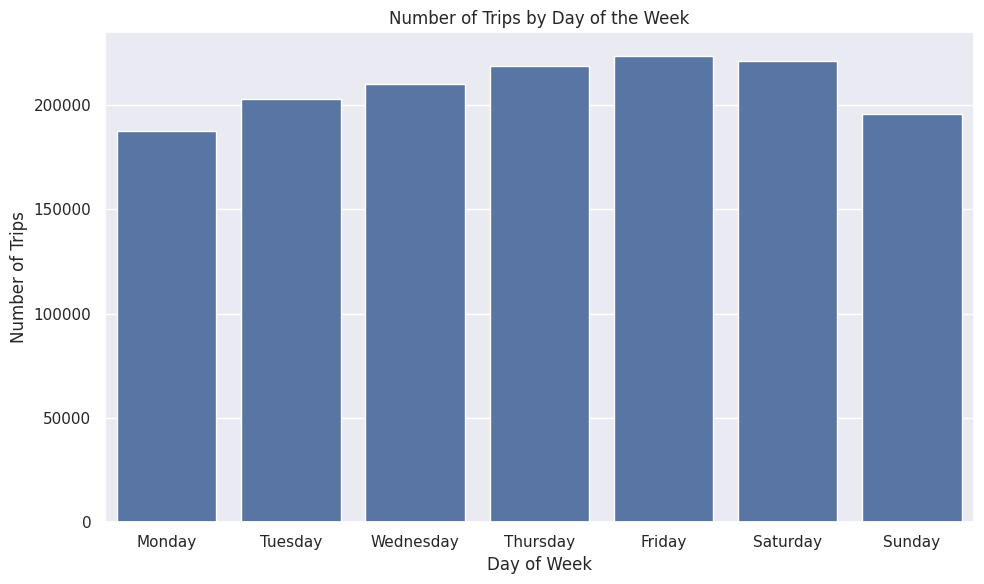

In [11]:
trips_per_weekday = df.groupby('weekday').size().reset_index(name='trip_count')
trips_per_weekday['weekday'] = trips_per_weekday['weekday'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_per_weekday['weekday'] = pd.Categorical(trips_per_weekday['weekday'], categories=ordered_days, ordered=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=trips_per_weekday, x='weekday', y='trip_count')
plt.title("Number of Trips by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()


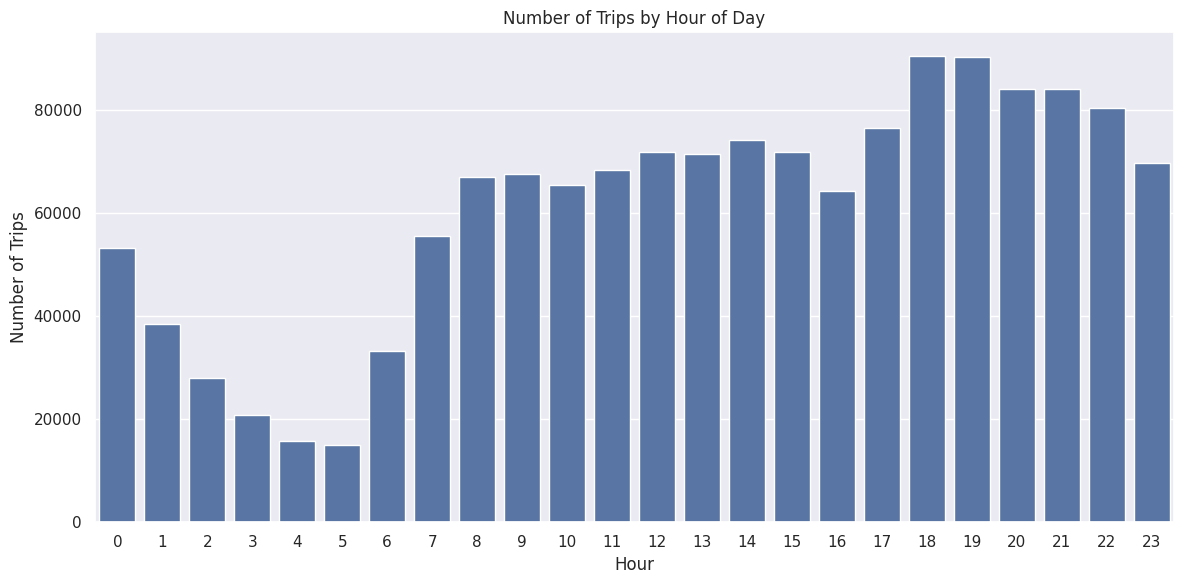

In [12]:
trips_per_hour = df.groupby('hour').size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
sns.barplot(data=trips_per_hour, x='hour', y='trip_count')
plt.title("Number of Trips by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

## Динамика поездок по часам: по месяцам и дням недели

Построим графики зависимости количества поездок от часа в сутках, отдельно по каждому месяцу и по дням недели. Это позволяет увидеть различия в поведенческих паттернах между буднями и выходными, а также сезонные эффекты.


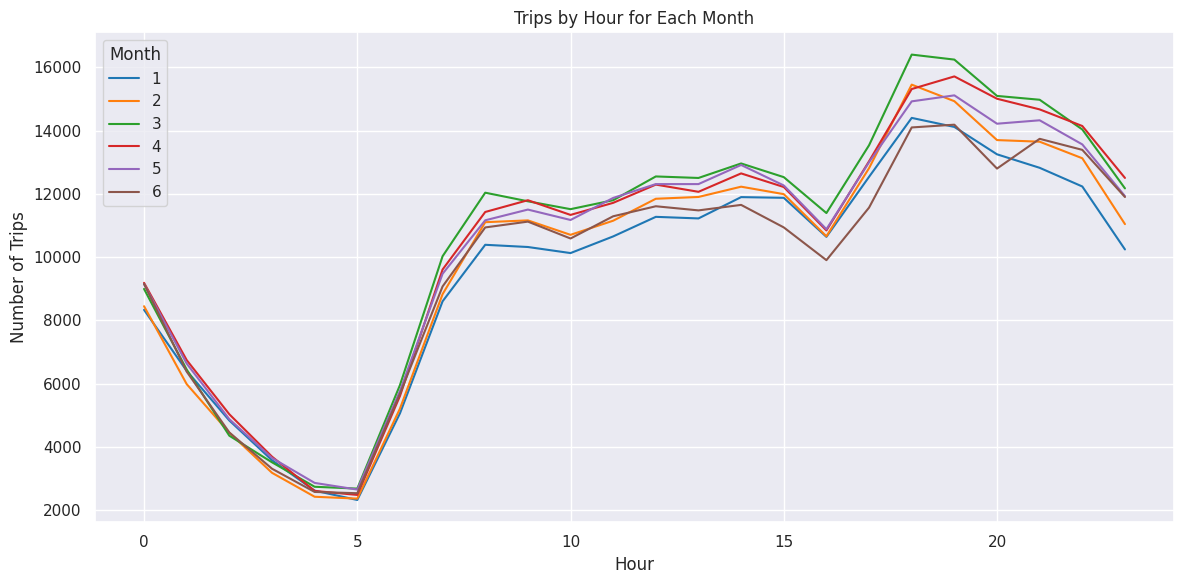

In [13]:
df["month"] = df["pickup_datetime"].dt.month
hour_month = df.groupby(["month", "hour"]).size().reset_index(name="trip_count")

plt.figure(figsize=(12, 6))
sns.lineplot(data=hour_month, x="hour", y="trip_count", hue="month", palette="tab10")
plt.title("Trips by Hour for Each Month")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.legend(title="Month")
plt.tight_layout()
plt.show()


## Выводы по временным графикам

По графикам заметно, что:

- В ночное время с 1:00 до 7:00 количество поездок минимально — это связано с тем, что большинство людей спят, а общественный транспорт и заведения работают ограниченно.
- Будние дни (особенно понедельник — четверг) имеют выраженные пики утром и вечером — это рабочие поездки.
- В пятницу и субботу позже появляются вечерние пики — вероятно, люди дольше находятся вне дома.
- Январь выделяется меньшим числом поездок — возможно, из-за плохой погоды или праздничного сезона.

Теперь увидим, как изменяется **среднее логарифмированное время поездки** по дню недели, часу и дню в году.


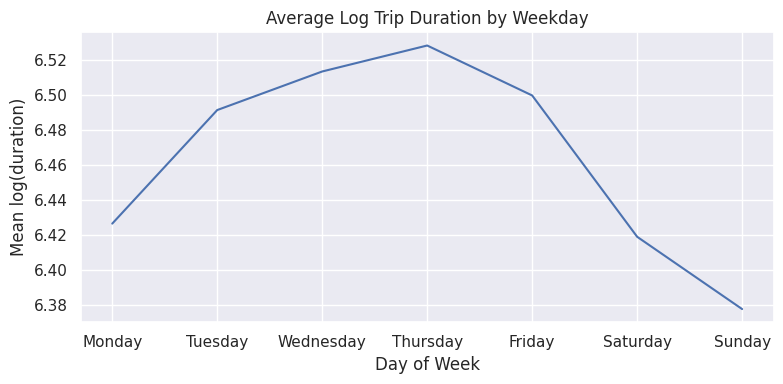

In [14]:
avg_by_weekday = df.groupby("weekday")["log_trip_duration"].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.lineplot(data=avg_by_weekday, x="weekday", y="log_trip_duration")
plt.title("Average Log Trip Duration by Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Mean log(duration)")
plt.xticks(ticks=range(7), labels=ordered_days)
plt.grid(True)
plt.tight_layout()
plt.show()


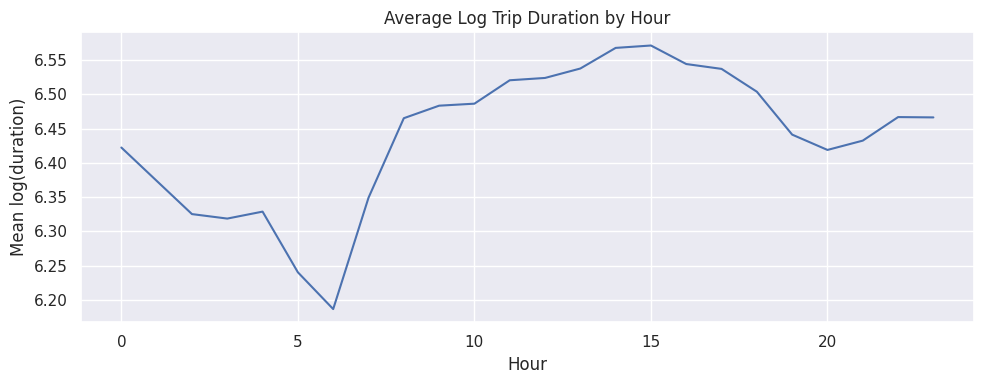

In [15]:
avg_by_hour = df.groupby("hour")["log_trip_duration"].mean().reset_index()
plt.figure(figsize=(10, 4))
sns.lineplot(data=avg_by_hour, x="hour", y="log_trip_duration")
plt.title("Average Log Trip Duration by Hour")
plt.xlabel("Hour")
plt.ylabel("Mean log(duration)")
plt.grid(True)
plt.tight_layout()
plt.show()


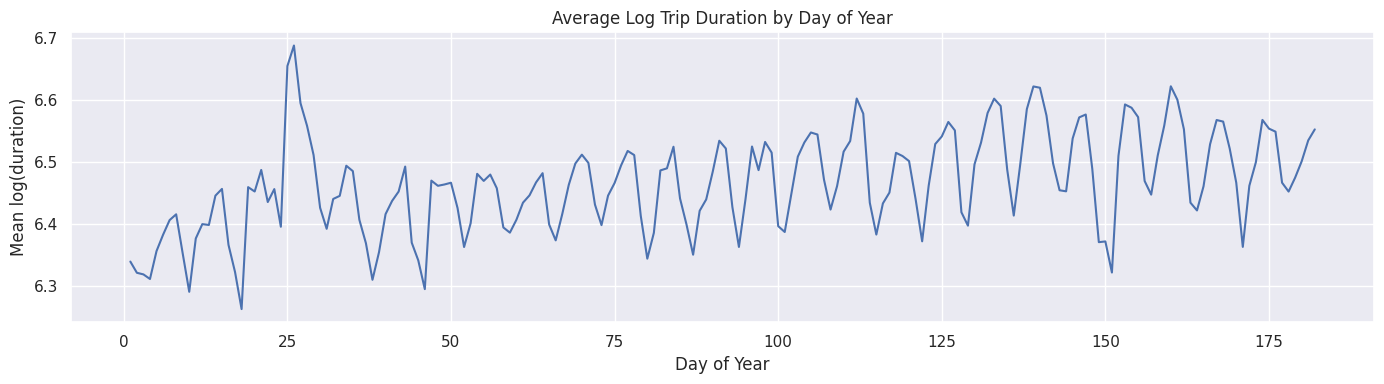

In [16]:
avg_by_day = df.groupby("num_day")["log_trip_duration"].mean().reset_index()
plt.figure(figsize=(14, 4))
sns.lineplot(data=avg_by_day, x="num_day", y="log_trip_duration")
plt.title("Average Log Trip Duration by Day of Year")
plt.xlabel("Day of Year")
plt.ylabel("Mean log(duration)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Поведение средней логарифмированной длительности поездки

- По дням недели средняя длительность почти не меняется, но немного ниже в выходные, особенно в воскресенье — возможно, из-за прогулок или поездок за город.
- По часам суток — длительность повышается ночью (особенно около 3–5 утра), когда меньше пробок, а поездки могут быть длиннее .
- По дню в году заметен один сильный выбросы — 25-26 января. Это дни после снежного шторма, когда движение в городе было ограничено.
- В целом, график по дню в году напоминает **периодическую функцию**: в будни поездки стабильнее, в праздники и выходные — более разбросаны.


In [17]:
anomalous_dates = [pd.to_datetime("2016-01-23").date(), pd.to_datetime("2016-01-24").date()]
df["is_blizzard"] = df["pickup_datetime"].dt.date.isin(anomalous_dates)

## Типы признаков

К категориальным признакам относятся:
- `weekday`, `hour`, `month` — дискретные временные признаки, значения которых не имеют числового смысла.
- `is_blizzard` — бинарный признак (0 или 1), тоже категориальный.

К численным признакам относятся:
- `num_day` — день в году, можно интерпретировать как числовой временной тренд.

Категориальные признаки не имеют упорядоченного расстояния между значениями, поэтому их нужно кодировать отдельно (например, one-hot). Численные признаки масштабируются для улучшения сходимости модели.


In [18]:
from sklearn.model_selection import train_test_split

features = ["weekday", "hour", "month", "is_blizzard", "num_day"]
X_train, X_test, y_train, y_test = train_test_split(df[features], df["log_trip_duration"], test_size=0.3, random_state=47)


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

categorical = ["weekday", "hour", "month", "is_blizzard"]
numerical = ["num_day"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numerical)
])

model = make_pipeline(preprocessor, Ridge())
model.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
y_pred = model.predict(X_test)
results.loc["Basic ridge"] = rmse(y_test, y_pred)
print(results)


                RMSLE
baseline     0.795759
Basic ridge  0.789507


## Изучаем координаты

Теперь рассмотрим координаты начала и конца поездки. Для визуализации используем карту, на которую нанесём точки `pickup` или `dropoff` для случайной подвыборки. Также отобразим сетку, которая поможет позже выделить пространственные признаки.


In [21]:
import folium

def show_circles_on_map(data, latitude_column, longitude_column, color):
    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location, zoom_start=12)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    kw = {
        "color": "blue",
        "fill": True,
        "fill_color": "red",
    }

    lat_c = data[latitude_column].mean()
    lng_c = data[longitude_column].mean()

    dx = (0.047 + 0.035) / 4
    dy = 0.1 / 6

    for i in range(6):
        for j in range(4):
            folium.Rectangle(
                bounds=[
                    [lat_c - 0.05 + i * dy, lng_c - 0.047 + j * dx],
                    [lat_c - 0.05 + (i + 1) * dy, lng_c - 0.047 + (j + 1) * dx]
                ],
                dash_array="5, 5",
                **kw
            ).add_to(m)

    return m


In [22]:
def in_rectangle(lat1, lng1, lat2, lng2, y, x, m=6, n=4):
    j = ((lat2 - y) / (lat2 - lat1) * m).astype(int)
    i = ((lng2 - x) / (lng2 - lng1) * n).astype(int)
    j = np.clip(j, 0, m - 1)
    i = np.clip(i, 0, n - 1)
    return j * n + i


In [23]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

## Признак расстояния

Одним из важнейших признаков является примерная длина маршрута. Мы не знаем точную траекторию поездки, но можем оценить её с помощью кратчайшего расстояния по сфере — `haversine`. Этот признак назовём `haversine`.


In [24]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [25]:
df.loc[:, 'haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)


## Логарифм расстояния

Поскольку мы предсказываем логарифм времени, логарифм расстояния будет линейно связанной с целевой переменной. \
Добавим колонку `log_haversine` = log($haversine$ + 1).


In [26]:
df["log_haversine"] = np.log1p(df["haversine"])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

haversine        0.573595
log_haversine    0.749882
dtype: float64


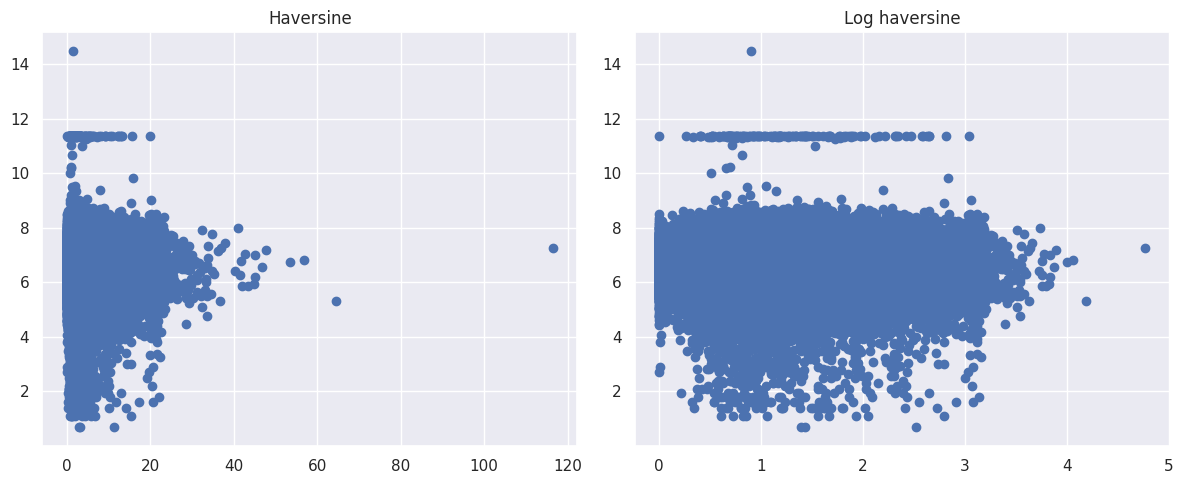

In [27]:
correlation = df[["haversine", "log_haversine"]].corrwith(df["log_trip_duration"])
print(correlation)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df["haversine"][:100000], y_train[:100000], marker='o')
plt.title("Haversine")

plt.subplot(1, 2, 2)
plt.scatter(df["log_haversine"][:100000], y_train[:100000], marker='o')
plt.title("Log haversine")

plt.tight_layout()
plt.show()

## Средняя скорость движения

Добавим признак `avg_speed`, равный расстоянию, делённому на продолжительность поездки (в часах). Построим его распределение


<Axes: >

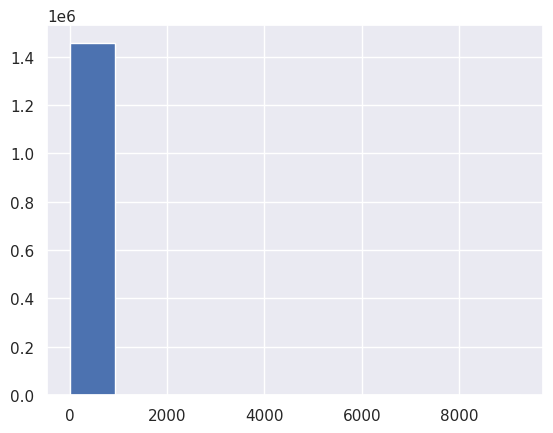

In [28]:
df["avg_speed"] = df["haversine"] / (df["trip_duration"] / 3600)
df['avg_speed'].hist()

Построим гистогамму средней скорости ограничив по квантили q = 0.99 для устранения выбросов.

<Axes: >

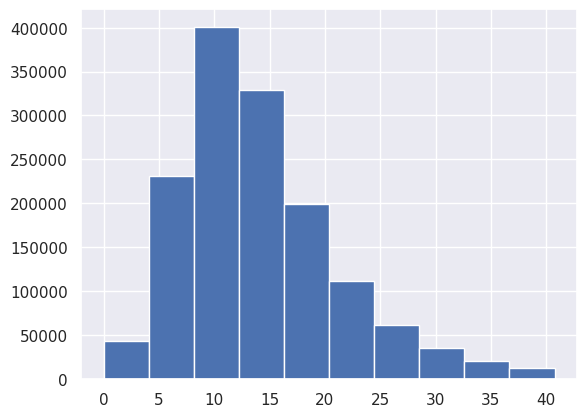

In [29]:
df[df['avg_speed']  <= df['avg_speed'].quantile(q=0.99)]['avg_speed'].hist()

## Медианная скорость по дню недели и часу

Чтобы изучить динамику скоростей в разное время, рассчитаем медианную скорость такси для каждой комбинации дня недели и часа. Отобразим результат с помощью тепловой карты.


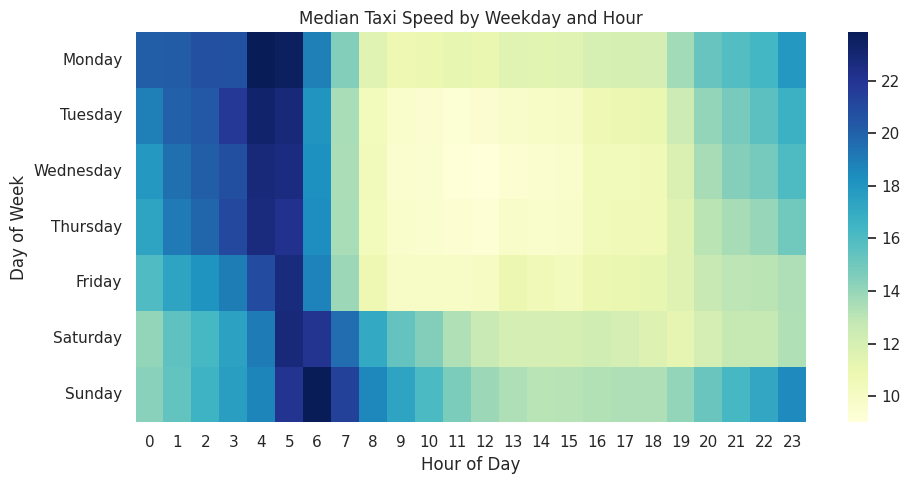

In [30]:
speed_grid = df.groupby(["weekday", "hour"])["avg_speed"].median().unstack()

plt.figure(figsize=(10, 5))
sns.heatmap(speed_grid, cmap="YlGnBu", annot=False, fmt=".1f")
plt.title("Median Taxi Speed by Weekday and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.yticks(ticks=np.arange(7)+0.5, labels=ordered_days, rotation=0)
plt.tight_layout()
plt.show()


## Признаки дорожной обстановки

Перед обучением модели удалим колонку `avg_speed`, так как она вычисляется на основе целевой переменной и недоступна при реальном прогнозировании.

### Почему нельзя использовать скорость?
Значение скорости напрямую зависит от таргета (`trip_duration`), а значит — является "протечкой" информации. Использование таких признаков приводит к переобучению и завышенной точности на валидации, которая не повторится на новых данных.

Добавим два новых признака:
- `is_rush_hour` — поездка совершается в утренние или вечерние часы буднего дня;
- `is_offpeak` — поездка совершается ночью или в выходные, когда дороги свободны.


In [31]:
rush_hours = list(range(7, 19))

df["is_rush_hour"] = ((df["hour"].isin(rush_hours)) & (df["weekday"] < 5)).astype(int)

offpeak_hours = list(range(0, 6))
df["is_offpeak"] = ((df["hour"].isin(offpeak_hours)) | (df["weekday"] >= 5)).astype(int)


## Признаки на основе координат

Для извлечения информации из координат, разобьём географическую область на прямоугольную сетку и сопоставим каждой поездке номер ячейки, в которой она началась и закончилась. Это позволит превратить нелинейные координаты в дискретные категориальные признаки.

Ниже реализован трансформер `MapGridTransformer`, который работает в стиле `sklearn`, не модифицирует данные inplace и поддерживает пайплайны.


In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, p_lat, p_lng, d_lat, d_lng, color, m=6, n=4):
        self.p_lat = p_lat
        self.p_lng = p_lng
        self.d_lat = d_lat
        self.d_lng = d_lng
        self.color = color
        self.m = m  # строк
        self.n = n  # столбцов

    def fit(self, X, y=None):
        self.lat1 = X[self.p_lat].mean() - 0.05
        self.lat2 = X[self.p_lat].mean() + 0.05
        self.lng1 = X[self.p_lng].mean() - 0.047
        self.lng2 = X[self.p_lng].mean() + 0.035
        return self

    def in_rectangle_vectorized(self, lat1, lng1, lat2, lng2, y, x, m, n):
        j = ((lat2 - y) / (lat2 - lat1) * m).astype(int)
        i = ((lng2 - x) / (lng2 - lng1) * n).astype(int)

        valid = (i >= 0) & (i < n) & (j >= 0) & (j < m)
        cell_number = j * n + i
        cell_number[~valid] = -1

        return cell_number

    def transform(self, X, y=None):
        X_new = X.copy()

        X_new["num_of_cell_pickup"] = self.in_rectangle_vectorized(
            self.lat1, self.lng1, self.lat2, self.lng2,
            X_new[self.p_lat].values,
            X_new[self.p_lng].values,
            self.m, self.n
        )

        X_new["num_of_cell_dropoff"] = self.in_rectangle_vectorized(
            self.lat1, self.lng1, self.lat2, self.lng2,
            X_new[self.d_lat].values,
            X_new[self.d_lng].values,
            self.m, self.n
        )

        return X_new

    def show_map(self, data, latitude_column, longitude_column):
        location = (data[latitude_column].mean(), data[longitude_column].mean())
        m = folium.Map(location=location, zoom_start=12)

        for _, row in data.iterrows():
            folium.Circle(
                radius=100,
                location=(row[latitude_column], row[longitude_column]),
                color=self.color,
                fill_color=self.color,
                fill=True
            ).add_to(m)

        kw = {
            "color": "blue",
            "fill": True,
            "fill_color": "red",
        }

        dx = (self.lng2 - self.lng1) / self.n
        dy = (self.lat2 - self.lat1) / self.m

        for i in range(self.m):
            for j in range(self.n):
                folium.Rectangle(
                    bounds=[
                        [self.lat1 + i * dy, self.lng1 + j * dx],
                        [self.lat1 + (i + 1) * dy, self.lng1 + (j + 1) * dx]
                    ],
                    dash_array="5,5",
                    **kw
                ).add_to(m)

        return m


In [33]:
y = df["log_trip_duration"]
df.drop(columns=["log_trip_duration", "trip_duration", "avg_speed", "haversine"], inplace=True)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=47)

In [35]:
from sklearn.preprocessing import FunctionTransformer

grid = MapGridTransformer(
    p_lat="pickup_latitude",
    p_lng="pickup_longitude",
    d_lat="dropoff_latitude",
    d_lng="dropoff_longitude",
    color="blue"
)

grid.fit(X_train)
grid_transform = FunctionTransformer(func=grid.transform, validate=False)

## Ridge-регрессия на всех текущих признаках

Обучим `Ridge`-регрессию на признаках, выделенных до этого момента. Для этого:
- категориальные признаки закодируем через `OneHotEncoder`;
- числовые — отмасштабируем с помощью `StandardScaler`.

Оценим качество модели на тестовой выборке по метрике RMSE.


In [36]:
from sklearn.pipeline import Pipeline

categorical = ["weekday", "hour", "num_of_cell_pickup", "num_of_cell_dropoff", \
               "is_rush_hour", "is_offpeak", "month", "weekday", "is_blizzard"]
numerical = ["log_haversine", "num_day"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numerical)
])

pipeline = Pipeline([
    ("grid", grid_transform),
    ("features", preprocessor),
    ("reg", Ridge())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


results.loc["ridge with grid_transform"] = rmse(y_test, y_pred)
print(results)

                              RMSLE
baseline                   0.795759
Basic ridge                0.789507
ridge with grid_transform  0.476976


Рассмотрим оставшиеся признаки, которые потенциально могут повлиять на длительность поездки:

- `vendor_id`: Идентификатор поставщика. У разных поставщиков могут быть разные алгоритмы маршрутизации, скорости подачи и т.д.
- `passenger_count`: Количество пассажиров. Это может косвенно влиять на стиль вождения, количество остановок или выбор маршрута.
- `store_and_fwd_flag`: Указывает, была ли информация сохранена в машине и отправлена позже. Может быть признаком нестабильной связи, типичной для определённых районов.

Посчитаем количество уникальных значений для каждого признака.


In [37]:
df[["vendor_id", "passenger_count", "store_and_fwd_flag"]].nunique()

vendor_id              2
passenger_count       10
store_and_fwd_flag     2
dtype: int64

### Исследуем влияние `vendor_id`, `passenger_count` и `store_and_fwd_flag`

Построим:

- boxplot'ы логарифма длительности поездки в зависимости от значений признаков;
- barplot'ы количества поездок для каждого значения.

Это поможет понять, влияют ли эти признаки на целевую переменную и стоит ли их включать в модель.


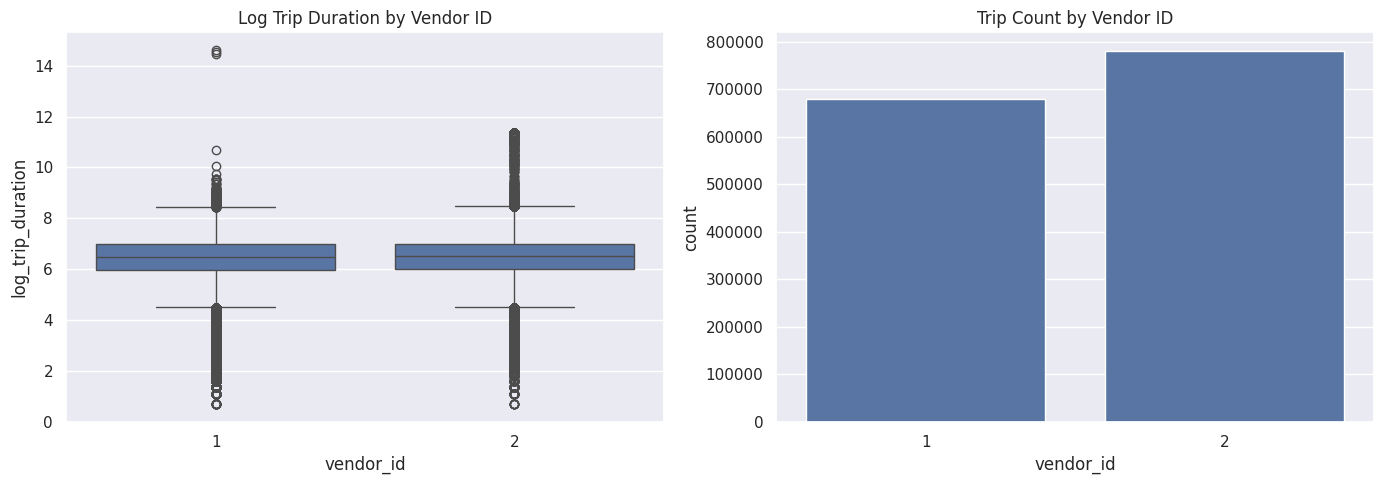

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x="vendor_id", y=y_train, ax=axes[0])
axes[0].set_title("Log Trip Duration by Vendor ID")

sns.countplot(data=df, x="vendor_id", ax=axes[1])
axes[1].set_title("Trip Count by Vendor ID")

plt.tight_layout()
plt.show()

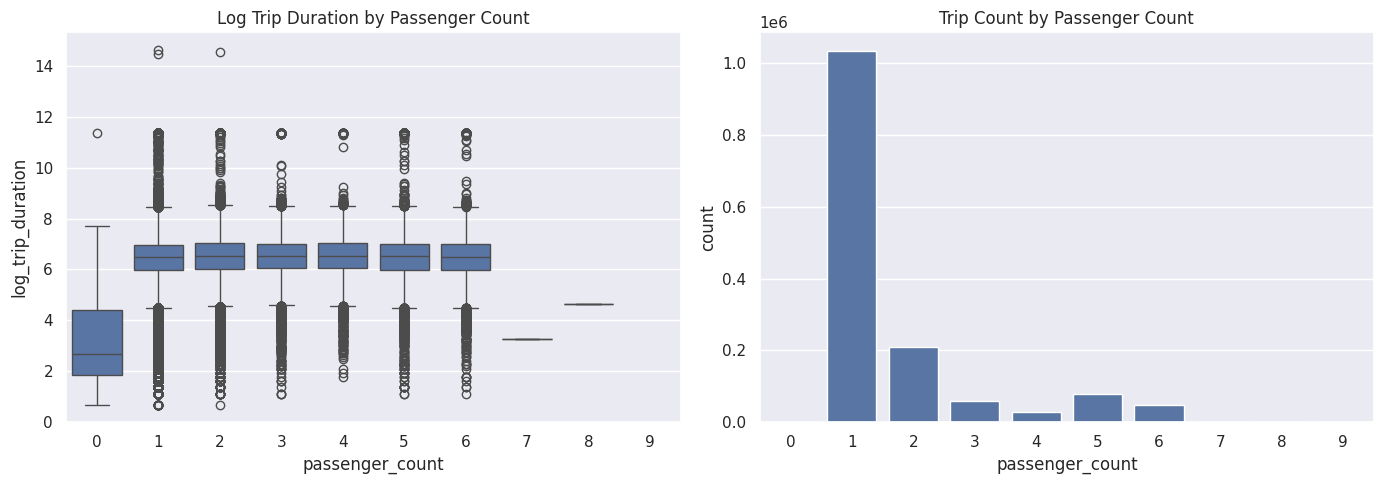

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x="passenger_count", y=y_train, ax=axes[0])
axes[0].set_title("Log Trip Duration by Passenger Count")

sns.countplot(data=df, x="passenger_count", ax=axes[1])
axes[1].set_title("Trip Count by Passenger Count")

plt.tight_layout()
plt.show()


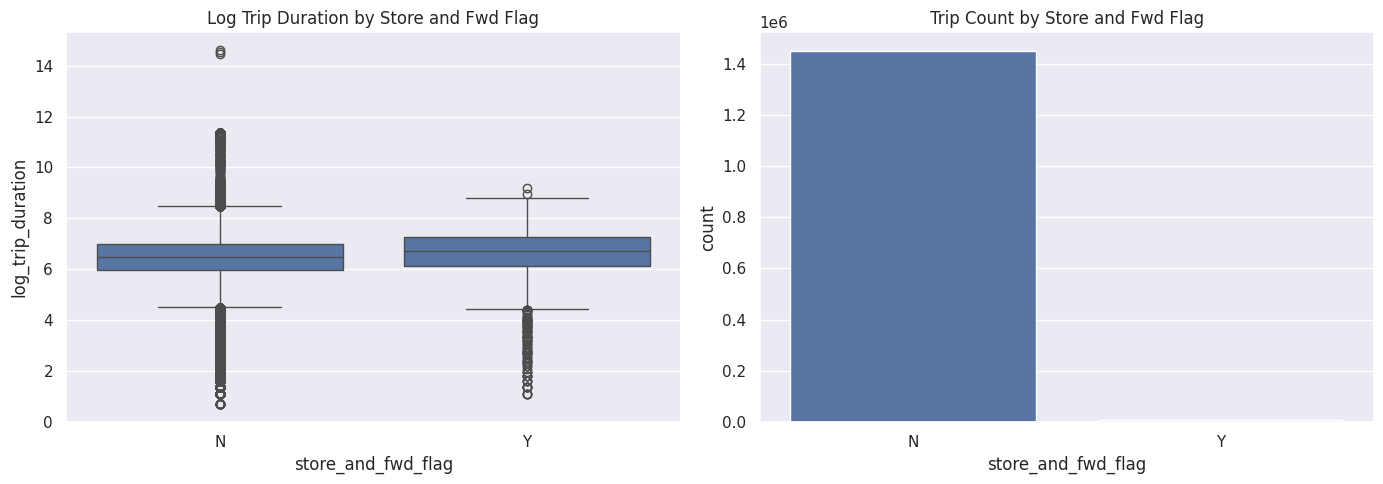

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x="store_and_fwd_flag", y=y_train, ax=axes[0])
axes[0].set_title("Log Trip Duration by Store and Fwd Flag")

sns.countplot(data=df, x="store_and_fwd_flag", ax=axes[1])
axes[1].set_title("Trip Count by Store and Fwd Flag")

plt.tight_layout()
plt.show()


Хотя boxplot'ы показывают, что распределения логарифма длительности поездки имеют много выбросов, это не значит, что признаки бесполезны. Мы проверим гипотезу, обучив `Ridge`-регрессию и включая:

- `vendor_id`
- `passenger_count`
- `store_and_fwd_flag`

Закодируем категориальные признаки one-hot-кодированием, числовые отмасштабируем.


In [41]:
extended_categorical = categorical + ["vendor_id", "store_and_fwd_flag"]
extended_numerical = numerical + ["passenger_count"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), extended_categorical),
    ("num", StandardScaler(), extended_numerical)
])

pipeline = Pipeline([
    ("grid", FunctionTransformer(func=grid.transform, validate=False)),
    ("features", preprocessor),
    ("reg", Ridge())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

results.loc["ridge with grid_transform and the remaining features"] = rmse(y_test, y_pred)
print(results)

                                                       RMSLE
baseline                                            0.795759
Basic ridge                                         0.789507
ridge with grid_transform                           0.476976
ridge with grid_transform and the remaining fea...  0.476774


### Вывод по признакам `vendor_id`, `passenger_count`, `store_and_fwd_flag`

Мы проверили гипотезу: обучили `Ridge`-регрессию, добавив к признакам `vendor_id`, `passenger_count`, `store_and_fwd_flag`.  
Однако модель не показала улучшения качества (по RMSLE) по сравнению с базовой.

Это означает, что данные признаки либо не несут полезной информации для предсказания длительности поездки, либо шумят, либо информация в них уже косвенно закодирована в других признаках.

 **Вывод:** эти признаки не будем использовать в дальнейшем.


## Улучшение
1. Изучим выбросы по следующим метрикам:
   - логарифм времени поездки;
   - расстояние поездки (`log_haversine`);
   - остатки модели (ошибки предсказания).

2. Удалим выбросы из обучающей выборки.

3. Объединим редкие категории в категориальных признаках в одну общую ("rare").

Удаление выбросов может ухудшить метрику на тесте, но зато приведёт к более стабильной, устойчивой модели, которая не подстраивается под шум.


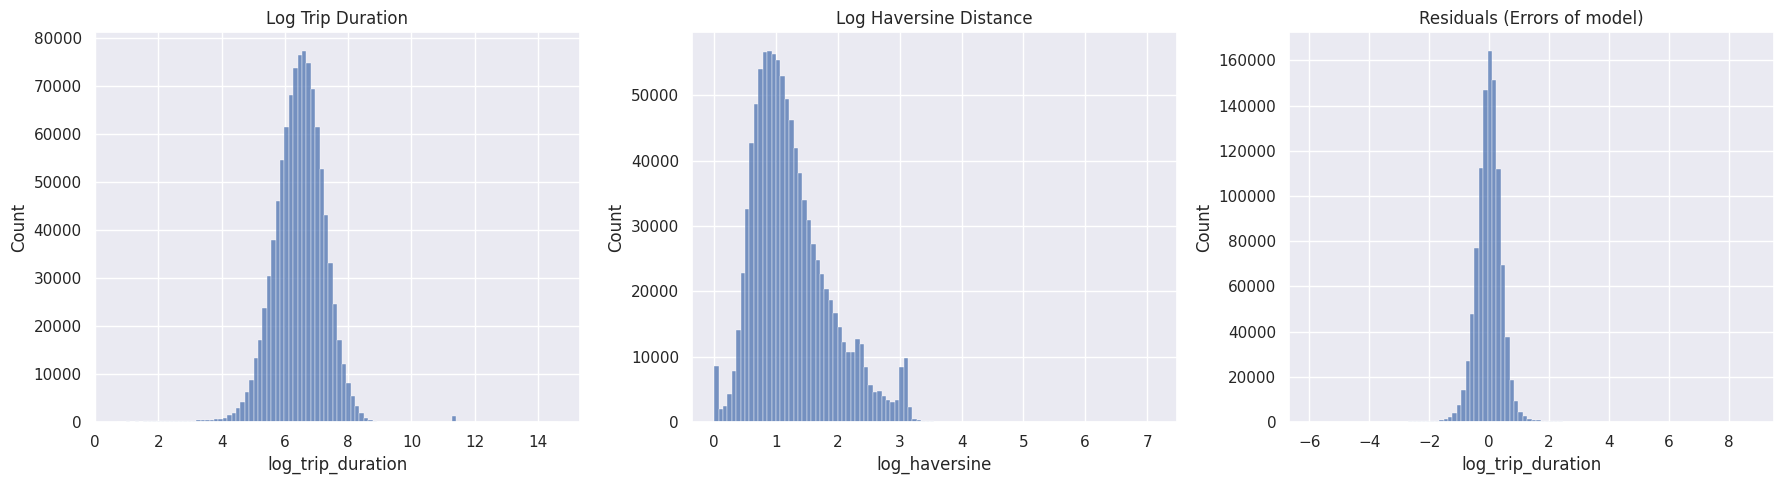

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(y_train, bins=100, ax=axes[0])
axes[0].set_title("Log Trip Duration")

sns.histplot(X_train["log_haversine"], bins=100, ax=axes[1])
axes[1].set_title("Log Haversine Distance")

residuals = y_train - pipeline.predict(X_train)
sns.histplot(residuals, bins=100, ax=axes[2])
axes[2].set_title("Residuals (Errors of model)")

plt.tight_layout()
plt.show()


In [43]:
mask = (
    (y_train > np.log1p(10)) &             
    (X_train["log_haversine"] < 3.8) &  
    (np.abs(residuals) < 2)         
)

X_train_cleaned = X_train[mask]
y_train_cleaned = y_train[mask]


In [44]:
print("Количество выбросов:", X_train.shape[0] - X_train_cleaned.shape[0])

Количество выбросов: 5604


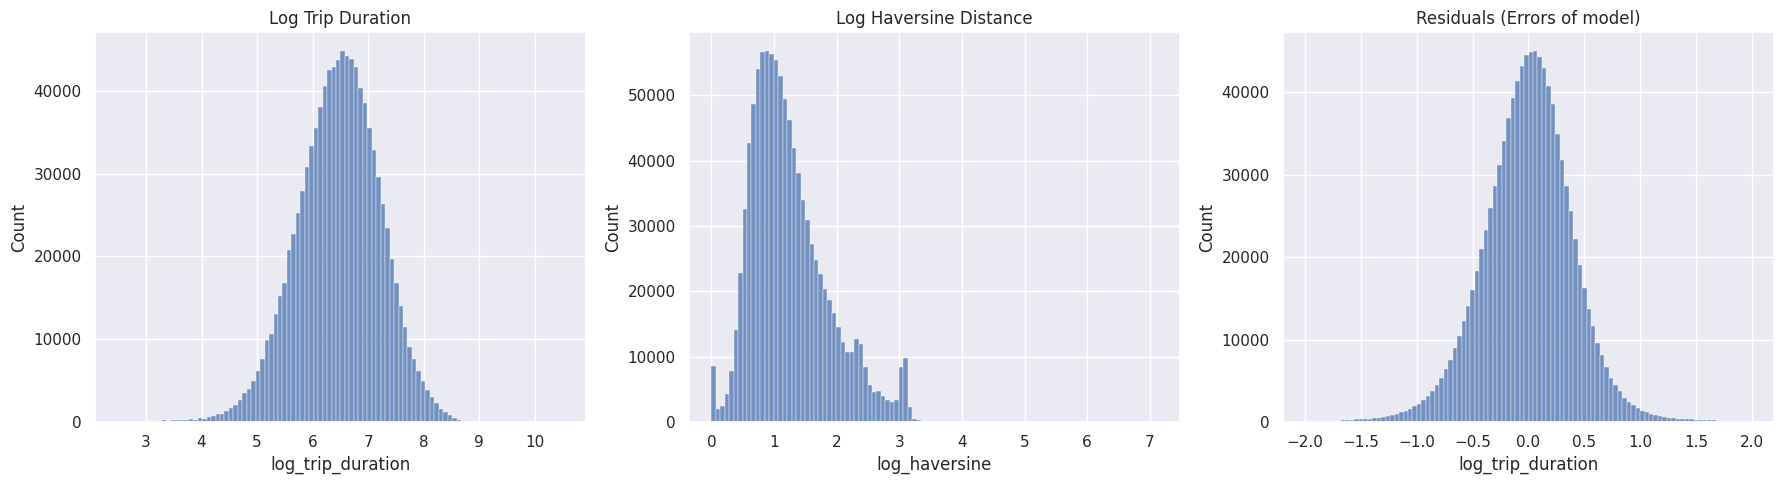

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(y_train_cleaned, bins=100, ax=axes[0])
axes[0].set_title("Log Trip Duration")

sns.histplot(X_train["log_haversine"], bins=100, ax=axes[1])
axes[1].set_title("Log Haversine Distance")

residuals = y_train_cleaned - pipeline.predict(X_train_cleaned)
sns.histplot(residuals, bins=100, ax=axes[2])
axes[2].set_title("Residuals (Errors of model)")

plt.tight_layout()
plt.show()


Таким образом данные приблизились к нормальному распределению

### Почему важно нормальное распределение ошибок в линейной регрессии?  

1. **Корректность статистических тестов**  
   t-тесты, F-тесты и доверительные интервалы требуют нормальности остатков.  

2. **Устойчивость на больших выборках**  
   Благодаря ЦПТ, даже при ненормальности данных, оценки асимптотически нормальны.  

3. **Интерпретация предсказаний**  
   Доверительные интервалы симметричны, а `E(y|X)` совпадает с медианой.  

In [46]:
X_train_cleaned = grid.transform(X_train_cleaned)
X_test = grid.transform(X_test)

In [47]:
def combine_rare_categories(df, column, min_count=50):
    freq = df[column].value_counts()
    rare_categories = freq[freq < min_count].index
    return df[column].apply(lambda x: "rare" if x in rare_categories else x)

for col in ["num_of_cell_pickup", "num_of_cell_dropoff"]:
    X_train_cleaned[col] = combine_rare_categories(X_train_cleaned, col)
    X_test[col] = combine_rare_categories(X_test, col)


### Модель на очищенных данных

Мы провели:

- очистку от выбросов по `log_trip_duration`, `log_haversine`, residual;
- объединение редких категорий в признаках `num_of_cell_pickup`, `num_of_cell_dropoff`;
- трансформацию координат с помощью MapGridTransformer;
- логарифмирование расстояния;
- стандартную предобработку признаков: масштабирование числовых и one-hot-кодирование категориальных.

Теперь обучим `Ridge`-регрессию на этих данных.


In [48]:
categorical = categorical + ["num_of_cell_pickup", "num_of_cell_dropoff"]
numerical = numerical + ["log_haversine"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numerical)
])

pipeline = Pipeline([
    ("grid", FunctionTransformer(func=grid.transform, validate=False)),
    ("preproc", preprocessor),
    ("reg", Ridge())
])

pipeline.fit(X_train_cleaned, y_train_cleaned)
y_pred = pipeline.predict(X_test)

score = rmse(y_test, y_pred)
results.loc["ridge -||- on cleaned data"] = score
print(score)

0.4771242980301956


Качество модели не выросло, но в итоге мы получили более интерпритируемую модель

### Признак "топ-100 маршрутов"

Добавим новый категориальный признак, который кодирует маршрут поездки — откуда и куда направлялось такси. В частности, мы определили маршрут как пару (ячейка отправления, ячейка назначения). Далее мы:
- Посчитаем количество вхождений каждой уникальной пары ячеек.
- Выделили 100 наиболее часто встречающихся маршрутов.
- Создали новый признак `top_route`, присваивая маршрутам из топ-100 уникальный идентификатор (строку), а остальным — значение `-1`.

> Пример маршрута: `'12_23'` означает поездку из ячейки 12 в ячейку 23.

In [49]:
from collections import Counter

routes = list(zip(X_train_cleaned["num_of_cell_pickup"], X_train_cleaned["num_of_cell_dropoff"]))

top_100_routes = set([route for route, _ in Counter(routes).most_common(100)])

In [50]:
def encode_route(pickup, dropoff):
    return f"{pickup}_{dropoff}" if (pickup, dropoff) in top_100_routes else "-1"

X_train_cleaned["top_route"] = [
    encode_route(p, d) for p, d in zip(X_train_cleaned["num_of_cell_pickup"], X_train_cleaned["num_of_cell_dropoff"])
]
X_test["top_route"] = [
    encode_route(p, d) for p, d in zip(X_test["num_of_cell_pickup"], X_test["num_of_cell_dropoff"])
]

In [51]:
for col in categorical:
    X_train_cleaned[col] = X_train_cleaned[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [52]:
from sklearn.linear_model import Lasso

categorical.append("top_route")

cat_pipeline = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ("scaler", StandardScaler(with_mean=False))  
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical), 
    ("num", StandardScaler(with_mean=False), numerical)
])
pipeline_ridge = Pipeline([
    ("features", preprocessor),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", Ridge())
])

pipeline_ridge.fit(X_train_cleaned, y_train[X_train_cleaned.index])
y_pred = pipeline_ridge.predict(X_test)

results.loc["ridge -||- with top route feature"] = rmse(y_test, y_pred)
print("RMSE Ridge на тесте:", rmse(y_test, y_pred))

RMSE Ridge на тесте: 0.4658546966921278


#### Почему такой признак полезен?

Хотя у модели уже есть признаки «из какой ячейки началась поездка» и «в какой ячейке закончилась», линейная регрессия не может самостоятельно учесть их взаимодействие. То есть:

- Для линейной модели признаки «ячейка отправления» и «ячейка назначения» действуют независимо.
- Но на самом деле важна их **комбинация** — маршрут.
- Например, поездка от ячейки 5 до ячейки 7 может занимать намного больше времени, чем от ячейки 5 до 6, даже если начало одно и то же.

Добавление этого признака позволяет модели явно учитывать самые частые маршруты и улучшать точность предсказания длительности поездки.


### Ridge,$ $ Lasso и выбор `alpha`

После one-hot-кодирования категориальных признаков размерность датасета увеличилась. Это может ухудшить обобщающую способность модели, особенно если в данных есть шум или нерелевантные признаки.

- сравним `Ridge` и `Lasso` по качеству на валидационной и тестовой выборках;
- подберем `alpha` по логарифмической сетке;
- для `Lasso` проанализируем число обнуленных коэффициентов в зависимости от `alpha`.

Также нас интересует, насколько сильно ухудшается качество модели, если мы хотим избавиться хотя бы от **половины признаков**.


In [53]:
X_train_preprocessed = preprocessor.fit_transform(X_train_cleaned)

print("До кодирования:", len(categorical) + len(numerical))
print("После кодирования:", X_train_preprocessed.shape[1])

До кодирования: 15
После кодирования: 250


In [54]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_cleaned,
    y_train_cleaned,
    test_size=0.2,
    random_state=47
)

In [55]:
alphas = np.logspace(-4, 4, 10)
ridge_scores = []
lasso_scores = []
lasso_nonzero = []


for alpha in alphas:

    lasso_pipe = Pipeline([
        ("grid", FunctionTransformer(func=grid.transform)),
        ("preproc", preprocessor),
        ("lasso", Lasso(alpha=alpha, max_iter=2000))
    ])
    
    ridge_pipe = Pipeline([
        ("grid", FunctionTransformer(func=grid.transform)),
        ("preproc", preprocessor),
        ("ridge", Ridge(alpha=alpha))
    ])

    ridge_pipe.fit(X_train_sub, y_train_sub)
    ridge_preds = ridge_pipe.predict(X_val_sub)
    ridge_scores.append(rmse(y_val_sub, ridge_preds))

    lasso_pipe.fit(X_train_sub, y_train_sub)
    lasso_preds = lasso_pipe.predict(X_val_sub)
    lasso_scores.append(rmse(y_val_sub, lasso_preds))

    nonzero_weights = np.sum(lasso_pipe.named_steps["lasso"].coef_ != 0)
    lasso_nonzero.append(nonzero_weights)

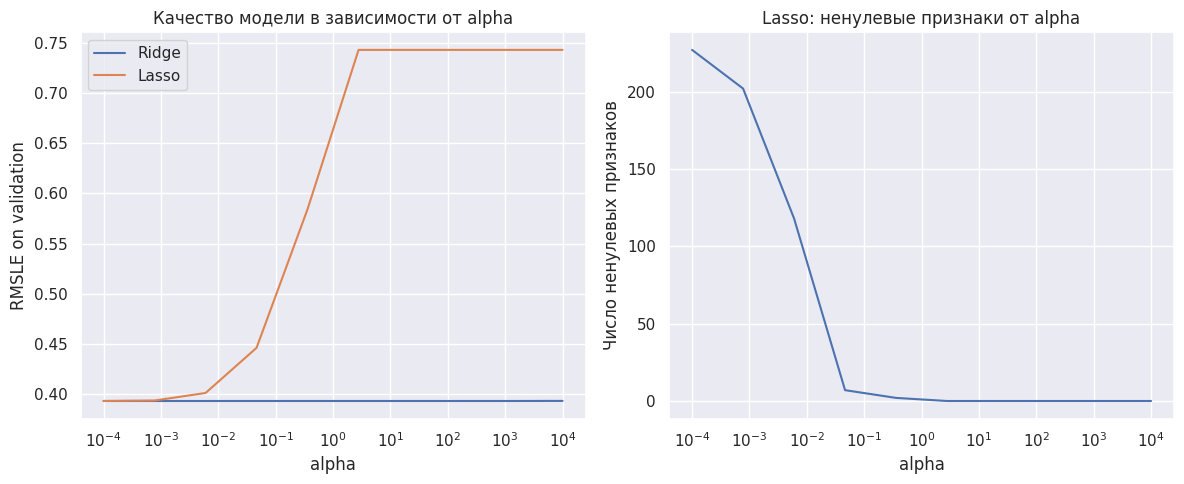

Лучший alpha (Ridge): 1291.5496650148827
Лучший alpha (Lasso): 0.0001


In [56]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(alphas, ridge_scores, label="Ridge")
plt.plot(alphas, lasso_scores, label="Lasso")
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("RMSLE on validation")
plt.title("Качество модели в зависимости от alpha")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_nonzero)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Число ненулевых признаков")
plt.title("Lasso: ненулевые признаки от alpha")

plt.tight_layout()
plt.show()

best_alpha_ridge = alphas[np.argmin(ridge_scores)]
best_alpha_lasso = alphas[np.argmin(lasso_scores)]

print("Лучший alpha (Ridge):", best_alpha_ridge)
print("Лучший alpha (Lasso):", best_alpha_lasso)

In [57]:
alpha_with_half_features = 1e-2

In [58]:
model_lasso = Pipeline([
    ("grid", FunctionTransformer(func=grid.transform, validate=False)),
    ("preproc", preprocessor),
    ("reg", Ridge(alpha=alpha_with_half_features))
])
model_lasso.fit(X_train_cleaned, y_train_cleaned)
y_pred = model_lasso.predict(X_test)

results.loc["lasso -||- with special alpha"] = rmse(y_test, y_pred)
print("RMSE Lasso на тесте:", rmse(y_test, y_pred))

RMSE Lasso на тесте: 0.4658551263733431


In [59]:
model_ridge = Pipeline([
    ("grid", FunctionTransformer(func=grid.transform, validate=False)),
    ("preproc", preprocessor),
    ("reg", Ridge(alpha=best_alpha_ridge))
])
model_lasso = Pipeline([
    ("grid", FunctionTransformer(func=grid.transform, validate=False)),
    ("preproc", preprocessor),
    ("reg", Ridge(alpha=best_alpha_lasso))
])

In [60]:
model_ridge.fit(X_train_cleaned, y_train_cleaned)
y_pred = model_ridge.predict(X_test)

results.loc["ridge -||- with best alpha"] = rmse(y_test, y_pred)
print("RMSE Ridge на тесте:", rmse(y_test, y_pred))

model_lasso.fit(X_train_cleaned, y_train_cleaned)
y_pred = model_lasso.predict(X_test)

results.loc["lasso -||- with best alpha"] = rmse(y_test, y_pred)
print("RMSE Lasso на тесте:", rmse(y_test, y_pred))

RMSE Ridge на тесте: 0.465875685274344
RMSE Lasso на тесте: 0.46585512581399663


In [61]:
print(results)

                                                       RMSLE
baseline                                            0.795759
Basic ridge                                         0.789507
ridge with grid_transform                           0.476976
ridge with grid_transform and the remaining fea...  0.476774
ridge -||- on cleaned data                          0.477124
ridge -||- with top route feature                   0.465855
lasso -||- with special alpha                       0.465855
ridge -||- with best alpha                          0.465876
lasso -||- with best alpha                          0.465855
